In [24]:
import tensorflow as tf
import numpy as np
import keras
from keras.preprocessing.image import load_img

import matplotlib.pyplot as plt
%matplotlib inline

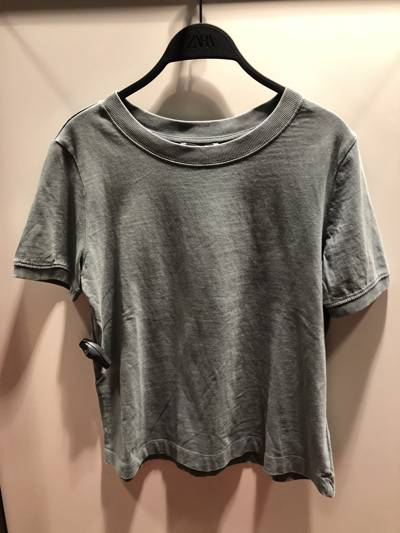

In [25]:
#посмотрим на изображение
fullname = 'clothing-dataset-small/test/t-shirt/0af4203f-8998-4719-92fe-65c14a6b6093.jpg'
load_img(fullname)

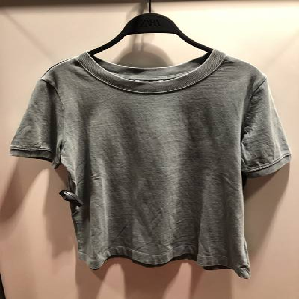

In [26]:
# изменим размер на ожидаеимый нейронной сетью(150 на 150 или 299 на 299)
load_img(fullname, target_size=(299,299))

# Использование предварительно обученной модели

In [27]:
from keras.applications.xception import Xception # фактическая модель
from keras.applications.xception import preprocess_input # функция для подготвоки изображения к испольованию моделью
from keras.applications.xception import decode_predictions # функцяи декодирования предсказания

In [28]:
model = Xception(
    weights='imagenet',
    input_shape=(299,299, 3)
)

In [29]:
img = load_img(fullname, target_size=(299,299))
x = np.array(img)
X = np.array([x])
X.shape

(1, 299, 299, 3)

In [30]:
X = preprocess_input(X)

## Получение прогнозов

In [31]:
pred = model.predict(X)
pred.shape

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


(1, 1000)

In [32]:
pred[0, :10]

array([1.3816642e-04, 5.7820540e-05, 7.1828363e-05, 5.4084048e-05,
       1.3338769e-04, 7.8178389e-05, 1.3208674e-04, 6.6248991e-05,
       5.3834105e-05, 5.3522912e-05], dtype=float32)

In [33]:
decode_predictions(pred)

[[('n03595614', 'jersey', np.float32(0.8117507)),
  ('n04370456', 'sweatshirt', np.float32(0.026505383)),
  ('n03980874', 'poncho', np.float32(0.01822685)),
  ('n02963159', 'cardigan', np.float32(0.010136365)),
  ('n04599235', 'wool', np.float32(0.006794122))]]

## Дообучение модели(с переносом опыта)

In [34]:
# Загружает в память изображения небольшими пакетами
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [35]:
train_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input # применяем к каждому изображению preprocess_input
)

In [36]:
train_ds = train_gen.flow_from_directory(
    "clothing-dataset-small/train",
    target_size = (150,150), # изменяем размер изображения на 150х150
    batch_size=32 # Загружаем изображения пакетами по 32 штуки
)

Found 3068 images belonging to 10 classes.


In [37]:
validation_gen = ImageDataGenerator(
    preprocessing_function = preprocess_input
)

image_size = (150,150)
batch_size=32

val_ds = validation_gen.flow_from_directory(
    "clothing-dataset-small/validation",
    target_size=image_size,
    batch_size=batch_size
)

Found 341 images belonging to 10 classes.


In [38]:
base_model = Xception(
    weights='imagenet',
    input_shape=(150, 150, 3),
    include_top = False # Сохраняем только сверточные слои
)

base_model.trainable = False

In [ ]:
# строим модель классификации одежды
inputs = keras.Input(shape=(150, 150, 3)) #входные изображения должны быт ь150 на 150

base = base_model(inputs, training=False) # Использует base_model для извлеченяи высокоуровневых признаков
pooling = keras.layers.GlobalAveragePooling2D() # создаем объединяющий слой
vector =pooling(base) # Соединяем его с base

outputs = keras.layers.Dense(10)(vector) # добавляет плотные слои размером 10 по одному элементу для каждого класса

model = keras.Model(inputs, outputs) # объединяем входные и выходные данный в модель Keras

## Обучение модели

In [40]:
learning_rate = 0.01
optimazer = keras.optimizers.Adam(learning_rate)
loss = keras.losses.CategoricalCrossentropy(from_logits=True)

In [41]:
model.compile(
    optimizer=optimazer,
    loss=loss,
    metrics=['accuracy']
)

In [42]:
model.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10


d:\DS_2025\ML_DL_clothing_classification\venv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


96/96 ━━━━━━━━━━━━━━━━━━━━ 104s 1s/step - accuracy: 0.5988 - loss: 1.4907 - val_accuracy: 0.7126 - val_loss: 1.0275
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 91s 952ms/step - accuracy: 0.8247 - loss: 0.5347 - val_accuracy: 0.7625 - val_loss: 0.8587
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 98s 1s/step - accuracy: 0.8542 - loss: 0.4145 - val_accuracy: 0.7801 - val_loss: 1.0439
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 107s 1s/step - accuracy: 0.9208 - loss: 0.2333 - val_accuracy: 0.8094 - val_loss: 0.9682
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 113s 1s/step - accuracy: 0.9427 - loss: 0.1518 - val_accuracy: 0.8182 - val_loss: 0.8913
Epoch 6/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 112s 1s/step - accuracy: 0.9642 - loss: 0.0984 - val_accuracy: 0.7889 - val_loss: 0.9844
Epoch 7/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 121s 1s/step - accuracy: 0.9738 - loss: 0.0801 - val_accuracy: 0.8094 - val_loss: 0.9135
Epoch 8/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 114s 1s/step - accuracy: 0.9847 - loss: 0.0577 - val_accuracy: 0.8065 - val_loss: 0

In [43]:
# переместим созданеи модели в функцию
def make_model(learning_rate):
  base_model = Xception(
    weights = 'imagenet',
    include_top=False,
    input_shape=(150,150,3))

  base_model.trainable = False

  inputs = keras.Input(shape=(150,150,3))

  base = base_model(inputs, training=False)
  vector = keras.layers.GlobalAveragePooling2D()(base)

  outputs = keras.layers.Dense(10)(vector)

  model = keras.Model(inputs, outputs)

  optimizer = keras.optimizers.Adam(learning_rate)

  loss = keras.losses.CategoricalCrossentropy(from_logits=True)

  model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=['accuracy'])

  return model

In [44]:
model = make_model(0.001)
model.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 91s 900ms/step - accuracy: 0.5005 - loss: 1.4784 - val_accuracy: 0.7713 - val_loss: 0.7328
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 92s 956ms/step - accuracy: 0.7942 - loss: 0.6330 - val_accuracy: 0.8065 - val_loss: 0.6389
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 101s 1s/step - accuracy: 0.8452 - loss: 0.4983 - val_accuracy: 0.7977 - val_loss: 0.5821
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 104s 1s/step - accuracy: 0.8694 - loss: 0.4216 - val_accuracy: 0.8182 - val_loss: 0.5561
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 101s 1s/step - accuracy: 0.8877 - loss: 0.3701 - val_accuracy: 0.8065 - val_loss: 0.5685
Epoch 6/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 102s 1s/step - accuracy: 0.9127 - loss: 0.3105 - val_accuracy: 0.8240 - val_loss: 0.5478
Epoch 7/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 101s 1s/step - accuracy: 0.9263 - loss: 0.2807 - val_accuracy: 0.8006 - val_loss: 0.5539
Epoch 8/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 98s 1s/step - accuracy: 0.9328 - loss: 0.2535 - val_accuracy: 0.8240 

In [45]:
model = make_model(0.0001)
model.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 96s 945ms/step - accuracy: 0.2556 - loss: 2.1056 - val_accuracy: 0.4897 - val_loss: 1.6001
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 99s 1s/step - accuracy: 0.5430 - loss: 1.4373 - val_accuracy: 0.6129 - val_loss: 1.2569
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 122s 1s/step - accuracy: 0.6282 - loss: 1.1873 - val_accuracy: 0.6481 - val_loss: 1.0781
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 130s 1s/step - accuracy: 0.6760 - loss: 1.0179 - val_accuracy: 0.6921 - val_loss: 0.9665
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 137s 1s/step - accuracy: 0.6954 - loss: 0.9331 - val_accuracy: 0.7419 - val_loss: 0.8862
Epoch 6/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 125s 1s/step - accuracy: 0.7246 - loss: 0.8487 - val_accuracy: 0.7478 - val_loss: 0.8360
Epoch 7/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 123s 1s/step - accuracy: 0.7437 - loss: 0.7947 - val_accuracy: 0.7654 - val_loss: 0.7922
Epoch 8/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 104s 1s/step - accuracy: 0.7539 - loss: 0.7468 - val_accuracy: 0.7654 - 